In [1]:
import kagglehub
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np
import os
# Optionally, display the test images with predictions
import matplotlib.pyplot as plt
import torchvision.utils as vutils

d:\Programming\CSULB\Fall 2024\CECS456\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Download latest version
path = kagglehub.dataset_download("andrewmvd/medical-mnist")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\hunter\.cache\kagglehub\datasets\andrewmvd\medical-mnist\versions\1


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# HyperParameters
num_epochs = 4
batch_size = 4
learning_rate = 0.001

In [9]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

from torch.utils.data import random_split

full_dataset = datasets.ImageFolder(root=path, transform=transform)

# Define split sizes
train_size = int(0.7 * len(full_dataset))
val_size = int(0.15 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size  # Remaining samples for test

# Random split
train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

In [5]:
# Define batch size
batch_size = 32

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

`nn.Conv2d(in_channels, out_channels, kernel_size)`

* This defines a 2D convolutional layer in PyTorch

* The parameters specify:
   * in_channels: The number of input channels in the image. In this case, its 1 because the images are grayscale
   * out_channels: the total number of filters (or feature maps) the convolutional will learn. In this case, the layer has 6 filters, so the output will have 6 channels.
   * kernel_size: the size of the filters applied to the input. In this case, the kernel size is 5, so the filter is a 5x5 matrix

In [6]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 13 * 13, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # First convolution + pooling
        x = self.pool(F.relu(self.conv2(x)))  # Second convolution + pooling
        x = x.view(x.size(0), -1)             # Flatten the tensor
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [19]:
# Metrics calculation function
def compute_metrics(model, dataloader, criterion, device):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # Calculate loss
            total_loss += loss.item()
            
            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    
    avg_loss = total_loss / len(dataloader)
    accuracy = correct / total
    return avg_loss, accuracy


In [21]:
model = ConvNet().to(device)
loss_train=[]
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

for epoch in range (num_epochs):
    running_loss = 0

    # Train Loader is the minibatch
    for images, labels in train_loader:
        # origin shape: [32, 3, 32, 32]
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Back prop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_train.append(loss.item())

        running_loss += loss.item()

    # Compute training and validation metrics
    train_loss, train_accuracy = compute_metrics(model, train_loader, criterion, device)
    test_loss, test_accuracy = compute_metrics(model, test_loader, criterion, device)
   
    print(f"Epoch [{epoch+1}/{num_epochs}]")
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

Epoch [1/4]
Train Loss: 0.5519, Train Accuracy: 0.9486
Test Loss: 0.5622, Test Accuracy: 0.9468
Epoch [2/4]
Train Loss: 0.1360, Train Accuracy: 0.9722
Test Loss: 0.1478, Test Accuracy: 0.9702
Epoch [3/4]
Train Loss: 0.0803, Train Accuracy: 0.9819
Test Loss: 0.0903, Test Accuracy: 0.9810
Epoch [4/4]
Train Loss: 0.0512, Train Accuracy: 0.9917
Test Loss: 0.0599, Test Accuracy: 0.9897


### Test Environment 
#### Predicting on the First 3 Images

Ground Truth Labels: ['Hand', 'HeadCT', 'Hand']
Predicted Labels: ['Hand', 'HeadCT', 'Hand']
Test Images:


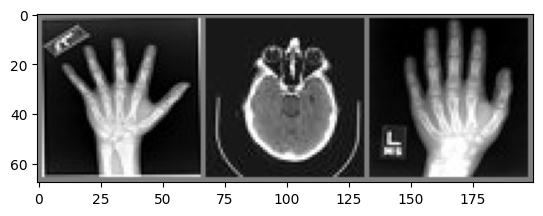

In [24]:
class_names = ['AbdomenCT', 'BreastMRI', 'CXR', 'ChestCT', 'Hand', 'HeadCT']

# Set the model to evaluation mode
model.eval()

# Disable gradient computation for inference
with torch.no_grad():
    # Get the first batch from the test DataLoader
    dataiter = iter(test_loader)
    images, labels = next(dataiter)  # Extract a batch of test data

    # Select the first three elements
    test_images = images[:3].to(device)  # Take the first 3 images
    test_labels = labels[:3].to(device)  # Corresponding labels

    # Pass the images through the model
    outputs = model(test_images)

    # Get the predicted classes
    _, predicted = torch.max(outputs, 1)  # Predicted class indices

    # Map numerical labels to class names
    ground_truth_names = [class_names[label] for label in test_labels.cpu().numpy()]
    predicted_names = [class_names[label] for label in predicted.cpu().numpy()]

    # Print the results
    print("Ground Truth Labels:", ground_truth_names)
    print("Predicted Labels:", predicted_names)

    # Unnormalize images for display
    def imshow(img):
        img = img / 2 + 0.5  # Unnormalize
        npimg = img.cpu().numpy()
        plt.imshow(np.transpose(npimg, (1, 2, 0)))
        plt.show()

    print("Test Images:")
    imshow(vutils.make_grid(test_images.cpu()))


Confusion Matrix:
[[1980    0    0    0    0    0]
 [   0 1737    0    0    0    0]
 [   6    0 1979    0   10    1]
 [   0    0    0 2023    0    0]
 [  10    4   12   20 1922   47]
 [   0    1    0    0   10 2029]]


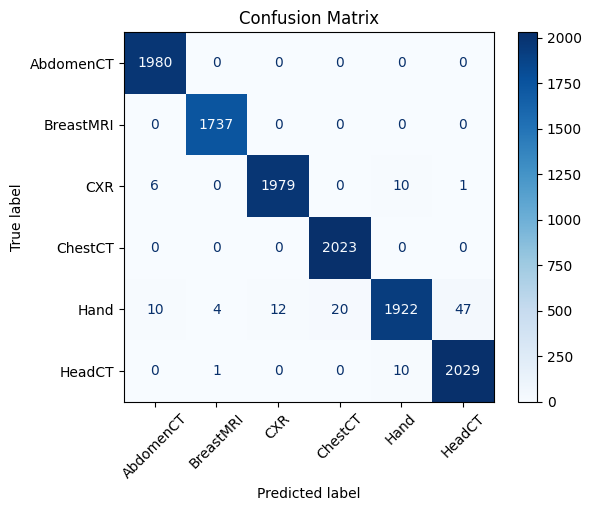

In [25]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

true_labels = []
predicted_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        
        # Get model predictions
        outputs = model(images)
        _, preds = torch.max(outputs, 1)  # Get the index of the max log-probability
        
        # Store true and predicted labels
        true_labels.extend(labels.cpu().numpy())  # Convert to numpy arrays
        predicted_labels.extend(preds.cpu().numpy())

# Step 2: Compute the Confusion Matrix
cm = confusion_matrix(true_labels, predicted_labels)
print("Confusion Matrix:")
print(cm)

# Step 3: Visualize the Confusion Matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)  # Rotate x-axis labels for better readability
plt.title("Confusion Matrix")
plt.show()